# Text Pre-Processing

## Necessary Imports

In [48]:
from keras.layers import Input, Dense, Dropout, LSTM, Embedding, Bidirectional
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from keras.models import Model, load_model
from keras.utils import to_categorical, plot_model
from PIL import Image
import matplotlib.pyplot as plt
from os import path
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import tensorflow
import tensorflow.keras as keras
from pickle import load
import numpy as np
from zipfile import ZipFile
import string
punctuations = string.punctuation

## Load data from file

In [2]:
def load_data(file, file_name):
    archive = ZipFile(file, mode='r')
    for files in archive.namelist():
        with archive.open(file_name, 'r') as file_to_read:
            descriptions = file_to_read.readlines()
    return descriptions

In [3]:
descriptions = load_data(
    'Flickr8k_text.zip', 'Flickr8k_text/Flickr8k.token.txt')

## Pre-processing captions and creating a dictionary of captions

In [4]:
def pre_process_descriptions(descriptions):
    descriptions_dict = {}
    for description in tqdm(descriptions):
        text = description.decode('iso8859-1').strip()
        image_details = text.split('\t')
        image_id, image_description = image_details[0].split('.')[
            0], image_details[1]
        tokens = image_description.split()
        tokens = [word.lower() for word in tokens if word not in punctuations]
        tokens = [word for word in tokens if len(word) > 1]
        tokens = [word for word in tokens if word.isalpha()]
        image_description = ' '.join(tokens)
        if image_id not in descriptions_dict.keys():
            descriptions_dict[image_id] = [image_description]
        else:
            descriptions_dict[image_id].append(image_description)
    return descriptions_dict

In [5]:
descriptions_dict = pre_process_descriptions(descriptions)

100%|██████████| 40460/40460 [00:00<00:00, 148416.79it/s]


## Saving the descriptions to a text file

In [6]:
def save_descriptions(descriptions_dict):
    descriptions = []
    for image_id, image_description in descriptions_dict.items():
        for description in image_description:
            descriptions.append(image_id + ',' + description)
    data = '\n'.join(descriptions)
    with open('descriptions.txt', 'w') as file_to_write:
        file_to_write.write(data)
    return

In [7]:
save_descriptions(descriptions_dict)

# Generating Train and Dev Datasets

## Extract image names from files

In [8]:
train_images = load_data(
    'Flickr8k_text.zip', 'Flickr8k_text/Flickr_8k.trainImages.txt')
dev_images = load_data('Flickr8k_text.zip',
                       'Flickr8k_text/Flickr_8k.devImages.txt')
test_images = load_data('Flickr8k_text.zip',
                        'Flickr8k_text/Flickr_8k.testImages.txt')

In [9]:
def clean_dataset(dataset):
    dataset_cleaned = [text.strip().decode('iso8859-1').split('.')[0]
                       for text in dataset]
    return dataset_cleaned

## Get Descriptions for Train, Dev and Test Images

In [10]:
def get_descriptions(dataset, descriptions):
    dataset_description = {}
    dataset_cleaned = clean_dataset(dataset)
    with open(descriptions, 'r') as file_to_read:
        image_descriptions = file_to_read.read()
    for line in image_descriptions.split('\n'):
        data = line.split(',')
        image_id, image_description = data[0], data[1]
        if image_id in dataset_cleaned:
            if image_id not in dataset_description.keys():
                dataset_description[image_id] = [
                    'strstart ' + str(image_description) + ' strend']
            else:
                dataset_description[image_id].append(
                    'strstart ' + str(image_description) + ' strend')
    return dataset_description

In [11]:
train_descriptions = get_descriptions(train_images, 'descriptions.txt')
dev_descriptions = get_descriptions(dev_images, 'descriptions.txt')
test_descriptions = get_descriptions(test_images, 'descriptions.txt')

## Get image features for Train, Dev and Test Images - VGG16

In [12]:
def get_features(features, dataset):
    dataset_cleaned = clean_dataset(dataset)
    file = load(open(features, 'rb'))
    image_features = {k: file[k] for k in dataset_cleaned}
    return image_features

In [13]:
train_image_features_vgg16 = get_features(
    'image_features/vgg16_features.pkl', train_images)
dev_image_features_vgg16 = get_features(
    'image_features/vgg16_features.pkl', dev_images)
test_image_features_vgg16 = get_features(
    'image_features/vgg16_features.pkl', test_images)

## Get image features for Train, Dev and Test Images - Xception

In [14]:
train_image_features_xcptn = get_features(
    'image_features/xception_features.pkl', train_images)
dev_image_features_xcptn = get_features(
    'image_features/xception_features.pkl', dev_images)
test_image_features_xcptn = get_features(
    'image_features/xception_features.pkl', test_images)

## Get image features for Train, Dev and Test Images - Inception V3

In [15]:
train_image_features_incptn = get_features(
    'image_features/inception_features.pkl', train_images)
dev_image_features_incptn = get_features(
    'image_features/inception_features.pkl', dev_images)
test_image_features_incptn = get_features(
    'image_features/inception_features.pkl', test_images)

## Get image features for Train,  Dev and Test Images - Resnet50

In [16]:
train_image_features_resnet = get_features(
    'image_features/resnet_features.pkl', train_images)
dev_image_features_resnet = get_features(
    'image_features/resnet_features.pkl', dev_images)
test_image_features_resnet = get_features(
    'image_features/resnet_features.pkl', test_images)

## Tokenizing the train and dev descriptions

In [17]:
def get_all_descriptions(descriptions_dict):
    list_of_descriptions = []
    for image_id in descriptions_dict.keys():
        [list_of_descriptions.append(description)
         for description in descriptions_dict[image_id]]
    return list_of_descriptions

In [18]:
def custom_tokenizer(descriptions_dict):
    list_of_descriptions = get_all_descriptions(descriptions_dict)
    tokenizer = Tokenizer(oov_token='<OOV>')
    tokenizer.fit_on_texts(list_of_descriptions)
    max_length = max(len(data.split()) for data in list_of_descriptions)
    return tokenizer, max_length

In [19]:
tokenizer, max_length = custom_tokenizer(train_descriptions)
print('Length of Vocabulary: {}'.format(len(tokenizer.word_index) + 1))
print('Max length of a description: {}'.format(max_length))

Length of Vocabulary: 7267
Max length of a description: 33


## Glove Vectors to generate word embeddings

In [20]:
# Get the GloVe vector word embeddings from Stanford NLP library
def generate_word_embeddings():
    if not path.exists('glove.6B.zip'):
        print('Please wait while the Global Vector Word Embeddings are being downloaded.')
        !wget http: // nlp.stanford.edu/data/glove.6B.zip
        !unzip glove*.zip
    word_embeddings = {}
    with open('glove.6B.300d.txt', encoding='utf-8') as file:
        for line in tqdm(file):
            words = line.split()
            word = words[0]
            word_vectors = np.asarray(words[1:], dtype='float32')
            word_embeddings[word] = word_vectors
    return word_embeddings


word_embeddings = generate_word_embeddings()

400000it [00:32, 12443.31it/s]


In [21]:
# Generating a Embedding matrix
def generate_embedding_matrix(word_embeddings):
    vocabulary_size = len(tokenizer.word_index)+1
    embedding_matrix = np.zeros((vocabulary_size, 300))
    for word, index in tokenizer.word_index.items():
        embedding_vector = word_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    return embedding_matrix, vocabulary_size

# Model Training

## Generate input and output sequences to train the model## Generate the sequences

In [22]:
def generate_sequence(descriptions, features, tokenizer, max_length):
    features_list, descriptions_list, output = [], [], []
    for image_id, descs in tqdm(descriptions.items()):
        for desc in descs:
            text_to_sequence = tokenizer.texts_to_sequences([desc])[0]
            for i in range(1, len(text_to_sequence)):
                input_sequence = text_to_sequence[:i]
                output_sequence = text_to_sequence[i]
                input_sequence = pad_sequences(
                    [input_sequence], maxlen=max_length)[0]
                output_sequence = to_categorical(
                    [output_sequence], num_classes=len(tokenizer.word_index)+1)[0]
                features_list.append(features[image_id][0])
                descriptions_list.append(input_sequence)
                output.append(output_sequence)
    return np.array(features_list), np.array(descriptions_list), np.array(output)

## Model Architecture

In [23]:
def image_caption_model(max_length, vocabulary_size, input_type, input_shape):
    embedding_matrix, vocabulary_size = generate_embedding_matrix(
        word_embeddings)
    cnn_inputs = Input(shape=(input_shape,), name='CNN_input')
    cnn_dropout = Dropout(0.5)(cnn_inputs)
    fully_connected_cnn = Dense(512, activation="relu")(cnn_dropout)
    lstm_inputs = Input(shape=(max_length,))
    embedding_layer = Embedding(vocabulary_size, 300, weights=[
                                embedding_matrix], mask_zero=True)(lstm_inputs)
    lstm_dropout = Dropout(0.5)(embedding_layer)
    lstm = Bidirectional(LSTM(256))(lstm_dropout)
    final_layer = add([fully_connected_cnn, lstm])
    final_fully_connected = Dense(512, activation='relu')(final_layer)
    model_output = Dense(vocabulary_size, activation="softmax")(
        final_fully_connected)
    model = Model(inputs=[cnn_inputs, lstm_inputs], outputs=model_output)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    print(model.summary())
    plot_model(model, to_file=input_type + '.png', show_shapes=True)
    return model

## Generate Training and Dev Data for VGG16

In [24]:
features_list_train, descriptions_list_train, output_train = generate_sequence(
    train_descriptions, train_image_features_vgg16, tokenizer, max_length)
features_list_dev, descriptions_list_dev, output_dev = generate_sequence(
    dev_descriptions, dev_image_features_vgg16, tokenizer, max_length)

100%|██████████| 1000/1000 [00:01<00:00, 531.28it/s]


### Generate model for VGG-16

In [25]:
model_with_vgg16 = image_caption_model(
    max_length, len(tokenizer.word_index) + 1, 'vgg16', 4096)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
CNN_input (InputLayer)          [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 300)      2180100     input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           CNN_input[0][0]                  
_______________________________________________________________________________________

### Train the model with VGG-16 Data

In [26]:
filepath = 'model_results/vgg16/model_with_vgg16-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
vgg_history = model_with_vgg16.fit([features_list_train, descriptions_list_train], output_train, callbacks=[
                                   checkpoint], epochs=5, verbose=1, validation_data=([features_list_dev, descriptions_list_dev], output_dev))

Epoch 1/5
9551/9551 [==============================] - ETA: 0s - loss: 4.4032
Epoch 00001: val_loss improved from inf to 4.11066, saving model to model_results/vgg16/model_with_vgg16-ep001-loss4.403-val_loss4.111.h5
9551/9551 [==============================] - 1752s 183ms/step - loss: 4.4032 - val_loss: 4.1107
Epoch 2/5
9551/9551 [==============================] - ETA: 0s - loss: 3.7880
Epoch 00002: val_loss improved from 4.11066 to 4.01970, saving model to model_results/vgg16/model_with_vgg16-ep002-loss3.788-val_loss4.020.h5
9551/9551 [==============================] - 1726s 181ms/step - loss: 3.7880 - val_loss: 4.0197
Epoch 3/5
9551/9551 [==============================] - ETA: 0s - loss: 3.5977
Epoch 00003: val_loss improved from 4.01970 to 3.98949, saving model to model_results/vgg16/model_with_vgg16-ep003-loss3.598-val_loss3.989.h5
9551/9551 [==============================] - 1735s 182ms/step - loss: 3.5977 - val_loss: 3.9895
Epoch 4/5
9551/9551 [==============================] - E

## Generate Training and Dev Data for Xception

In [27]:
features_list_train, descriptions_list_train, output_train = generate_sequence(
    train_descriptions, train_image_features_xcptn, tokenizer, max_length)
features_list_dev, descriptions_list_dev, output_dev = generate_sequence(
    dev_descriptions, dev_image_features_xcptn, tokenizer, max_length)

100%|██████████| 1000/1000 [00:01<00:00, 555.41it/s]


### Generate model for Xception

In [28]:
model_with_xception = image_caption_model(
    max_length, len(tokenizer.word_index) + 1, 'xception', 2048)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
CNN_input (InputLayer)          [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 33, 300)      2180100     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           CNN_input[0][0]                  
_______________________________________________________________________________________

### Train the model with Xception Data

In [29]:
filepath = 'model_results/xception/model_with_xception-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
xception_history = model_with_xception.fit([features_list_train, descriptions_list_train], output_train, callbacks=[
                                           checkpoint], epochs=5, verbose=1, validation_data=([features_list_dev, descriptions_list_dev], output_dev))

Epoch 1/5
9551/9551 [==============================] - ETA: 0s - loss: 4.2016
Epoch 00001: val_loss improved from inf to 3.90910, saving model to model_results/xception/model_with_xception-ep001-loss4.202-val_loss3.909.h5
9551/9551 [==============================] - 1845s 193ms/step - loss: 4.2016 - val_loss: 3.9091
Epoch 2/5
9551/9551 [==============================] - ETA: 0s - loss: 3.5525
Epoch 00002: val_loss improved from 3.90910 to 3.83804, saving model to model_results/xception/model_with_xception-ep002-loss3.553-val_loss3.838.h5
9551/9551 [==============================] - 1805s 189ms/step - loss: 3.5525 - val_loss: 3.8380
Epoch 3/5
9551/9551 [==============================] - ETA: 0s - loss: 3.3499
Epoch 00003: val_loss did not improve from 3.83804
9551/9551 [==============================] - 1769s 185ms/step - loss: 3.3499 - val_loss: 3.8502
Epoch 4/5
9551/9551 [==============================] - ETA: 0s - loss: 3.2503
Epoch 00004: val_loss did not improve from 3.83804
9551/9

## Generate Training and Dev Data for Inception V3

In [30]:
features_list_train, descriptions_list_train, output_train = generate_sequence(
    train_descriptions, train_image_features_incptn, tokenizer, max_length)
features_list_dev, descriptions_list_dev, output_dev = generate_sequence(
    dev_descriptions, dev_image_features_incptn, tokenizer, max_length)
features_list_test, descriptions_list_test, output_test = generate_sequence(
    test_descriptions, test_image_features_incptn, tokenizer, max_length)

100%|██████████| 1000/1000 [00:01<00:00, 567.23it/s]


### Generate model for Inception V3

In [31]:
model_with_inception = image_caption_model(
    max_length, len(tokenizer.word_index) + 1, 'inception', 2048)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
CNN_input (InputLayer)          [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 33, 300)      2180100     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 2048)         0           CNN_input[0][0]                  
_______________________________________________________________________________________

### Train the model with Inception V3 Data

In [32]:
filepath = 'model_results/inceptionv3/model_with_inception-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
inception_history = model_with_inception.fit([features_list_train, descriptions_list_train], output_train, callbacks=[
                                             checkpoint], epochs=5, verbose=1, validation_data=([features_list_dev, descriptions_list_dev], output_dev))

Epoch 1/5
9551/9551 [==============================] - ETA: 0s - loss: 4.2341
Epoch 00001: val_loss improved from inf to 3.97615, saving model to model_results/inceptionv3/model_with_inception-ep001-loss4.234-val_loss3.976.h5
9551/9551 [==============================] - 1836s 192ms/step - loss: 4.2341 - val_loss: 3.9762
Epoch 2/5
9551/9551 [==============================] - ETA: 0s - loss: 3.6134
Epoch 00002: val_loss improved from 3.97615 to 3.88188, saving model to model_results/inceptionv3/model_with_inception-ep002-loss3.613-val_loss3.882.h5
9551/9551 [==============================] - 1837s 192ms/step - loss: 3.6134 - val_loss: 3.8819
Epoch 3/5
9551/9551 [==============================] - ETA: 0s - loss: 3.4202
Epoch 00003: val_loss improved from 3.88188 to 3.87698, saving model to model_results/inceptionv3/model_with_inception-ep003-loss3.420-val_loss3.877.h5
9551/9551 [==============================] - 1823s 191ms/step - loss: 3.4202 - val_loss: 3.8770
Epoch 4/5
9551/9551 [=====

## Generate Training and Dev Data for Resnet50

In [25]:
features_list_train, descriptions_list_train, output_train = generate_sequence(
    train_descriptions, train_image_features_resnet, tokenizer, max_length)
features_list_dev, descriptions_list_dev, output_dev = generate_sequence(
    dev_descriptions, dev_image_features_resnet, tokenizer, max_length)

100%|██████████| 1000/1000 [00:01<00:00, 535.83it/s]


### Generate model for Resnet50

In [26]:
model_with_resnet = image_caption_model(
    max_length, len(tokenizer.word_index) + 1, 'resnet', 2048)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
CNN_input (InputLayer)          [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 300)      2180100     input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           CNN_input[0][0]                  
_______________________________________________________________________________________

### Train the model with Resnet50 Data

In [27]:
filepath = 'model_results/resnet50/model_with_resnet-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
resnet_history = model_with_resnet.fit([features_list_train, descriptions_list_train], output_train, callbacks=[
                                       checkpoint], epochs=5, verbose=1, validation_data=([features_list_dev, descriptions_list_dev], output_dev))

Epoch 1/5
9551/9551 [==============================] - ETA: 0s - loss: 4.2956
Epoch 00001: val_loss improved from inf to 4.01620, saving model to model_results/resnet50/model_with_resnet-ep001-loss4.296-val_loss4.016.h5
9551/9551 [==============================] - 1581s 166ms/step - loss: 4.2956 - val_loss: 4.0162
Epoch 2/5
9551/9551 [==============================] - ETA: 0s - loss: 3.6914
Epoch 00002: val_loss improved from 4.01620 to 3.95054, saving model to model_results/resnet50/model_with_resnet-ep002-loss3.691-val_loss3.951.h5
9551/9551 [==============================] - 1593s 167ms/step - loss: 3.6914 - val_loss: 3.9505
Epoch 3/5
9551/9551 [==============================] - ETA: 0s - loss: 3.5046
Epoch 00003: val_loss improved from 3.95054 to 3.91957, saving model to model_results/resnet50/model_with_resnet-ep003-loss3.505-val_loss3.920.h5
9551/9551 [==============================] - 1601s 168ms/step - loss: 3.5046 - val_loss: 3.9196
Epoch 4/5
9551/9551 [=======================

# Model Evaluation on Dev Dataset

In [25]:
def get_word(feature, tokenizer):
    for word, index in tokenizer.word_index.items():
        if feature == index:
            return word
    return None

## Function to predict the caption provided an image

In [26]:
def predict_description(model, features, tokenizer, max_length):
    start_text = 'strstart'
    for i in range(max_length):
        text = tokenizer.texts_to_sequences([start_text])[0]
        text = pad_sequences([text], maxlen=max_length)
        output = model.predict([features, text], verbose=1)
        output = np.argmax(output)
        word_predicted = get_word(output, tokenizer)
        if word_predicted is None:
            break
        start_text += ' ' + word_predicted
        if word_predicted == 'strend':
            break
    return start_text

## Function to generate the Individual and Cummulative BLEU Scores

In [27]:
def evaluate(model, features, descriptions, tokenizer, max_length):
    predicted, actual = [], []
    for image_id, description in descriptions.items():
        output = predict_description(
            model, features[image_id], tokenizer, max_length)
        actual.append([data.split() for data in description])
        predicted.append(output.split())
        print('Individual BLEU-1 gram: {}'.format(round(corpus_bleu(actual,
                                                                    predicted, weights=(1.0, 0, 0, 0)), 4)))
        print('Individual BLEU-2 gram: {}'.format(round(corpus_bleu(actual,
                                                                    predicted, weights=(0, 1, 0, 0)), 4)))
        print('Individual BLEU-3 gram: {}'.format(round(corpus_bleu(actual,
                                                                    predicted, weights=(0, 0, 1, 0)), 4)))
        print('Individual BLEU-4 gram: {}'.format(round(corpus_bleu(actual,
                                                                    predicted, weights=(0, 0, 0, 1)), 5)))
        print('Cummulative BLEU-2 gram: {}'.format(round(corpus_bleu(actual,
                                                                     predicted, weights=(0.5, 0.5, 0, 0)), 4)))
        print('Cummulative BLEU-3 gram: {}'.format(round(corpus_bleu(actual,
                                                                     predicted, weights=(0.33, 0.33, 0.33, 0)), 4)))
        break
    return

## Evaluate VGG16 Model on Dev data

In [74]:
final_model = load_model(
    'model_results/vgg16/model_with_vgg16-ep003-loss3.598-val_loss3.989.h5')
evaluate(final_model, dev_image_features_vgg16,
         dev_descriptions, tokenizer, max_length)

1/1 [==============================] - 0s 2ms/step
Individual BLEU-1 gram: 0.6667
Individual BLEU-2 gram: 0.375
Individual BLEU-3 gram: 0.2857
Individual BLEU-4 gram: 0.16667
Cummulative BLEU-2 gram: 0.5
Cummulative BLEU-3 gram: 0.4186


## Evaluate Xception Model on Dev data

In [75]:
final_model = load_model(
    'model_results/xception/model_with_xception-ep002-loss3.553-val_loss3.838.h5')
evaluate(final_model, dev_image_features_xcptn,
         dev_descriptions, tokenizer, max_length)

1/1 [==============================] - 0s 3ms/step
Individual BLEU-1 gram: 0.8889
Individual BLEU-2 gram: 0.625
Individual BLEU-3 gram: 0.4286
Individual BLEU-4 gram: 0.16667
Cummulative BLEU-2 gram: 0.7454
Cummulative BLEU-3 gram: 0.6228


## Evaluate Inception V3 Model on Dev data

In [76]:
final_model = load_model(
    'model_results/inceptionv3/model_with_inception-ep003-loss3.420-val_loss3.877.h5')
evaluate(final_model, dev_image_features_incptn,
         dev_descriptions, tokenizer, max_length)

1/1 [==============================] - 0s 2ms/step
Individual BLEU-1 gram: 0.5
Individual BLEU-2 gram: 0.0909
Individual BLEU-3 gram: 0.0
Individual BLEU-4 gram: 0.0
Cummulative BLEU-2 gram: 0.2132
Cummulative BLEU-3 gram: 0.0


## Evaluate Resnet50 Model for Dev data

In [77]:
final_model = load_model(
    'model_results/resnet50/model_with_resnet-ep003-loss3.505-val_loss3.920.h5')
evaluate(final_model, dev_image_features_resnet,
         dev_descriptions, tokenizer, max_length)

1/1 [==============================] - 0s 1ms/step
Individual BLEU-1 gram: 0.4286
Individual BLEU-2 gram: 0.1538
Individual BLEU-3 gram: 0.0833
Individual BLEU-4 gram: 0.0
Cummulative BLEU-2 gram: 0.2568
Cummulative BLEU-3 gram: 0.1795


# Model Evaluation on Test data

In [29]:
features_list_test, descriptions_list_test, output_test = generate_sequence(
    test_descriptions, test_image_features_xcptn, tokenizer, max_length)
final_model = load_model(
    'model_results/xception/model_with_xception-ep002-loss3.553-val_loss3.838.h5')
evaluate(final_model, test_image_features_xcptn,
         test_descriptions, tokenizer, max_length)

100%|██████████| 1000/1000 [00:01<00:00, 539.92it/s]


1/1 [==============================] - 0s 2ms/step
Individual BLEU-1 gram: 0.4
Individual BLEU-2 gram: 0.1111
Individual BLEU-3 gram: 0.0
Individual BLEU-4 gram: 0.0
Cummulative BLEU-2 gram: 0.2108
Cummulative BLEU-3 gram: 0.0


# Examples of Good and Bad Captions

## Function to predict captions for individual image

In [75]:
def example(image, model, features, tokenizer, max_length):
    plt.imshow(Image.open('Flickr8k_Dataset/Flicker8k_Dataset/' + image + '.jpg'))
    print('Actual Captions:\n')
    print("\n".join(test_descriptions[image]))
    print('\n Predicted Caption:\n')
    print(predict_description(model, features, tokenizer, max_length))
    return

## Good Caption

Actual Captions:

strstart boy in his blue swim shorts at the beach strend
strstart boy smiles for the camera at beach strend
strstart young boy in swimming trunks is walking with his arms outstretched on the beach strend
strstart children playing on the beach strend
strstart the boy is playing on the shore of an ocean strend

 Predicted Caption:

1/1 [==============================] - 0s 2ms/step
strstart two children are playing in the water strend


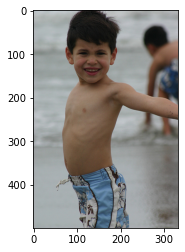

In [76]:
example('106490881_5a2dd9b7bd', final_model,
        test_image_features_xcptn['106490881_5a2dd9b7bd'], tokenizer, max_length)

## Better Caption

Actual Captions:

strstart crowd of people walk down busy sidewalk strend
strstart group of different people are walking in all different directions in city strend
strstart group of people walking city street in warm weather strend
strstart busy intersection in the summer time in city strend
strstart people in summer clothes are walking on the sidewalk of large city strend

 Predicted Caption:

1/1 [==============================] - 0s 2ms/step
strstart man in black shirt and black jacket is standing in front of building strend


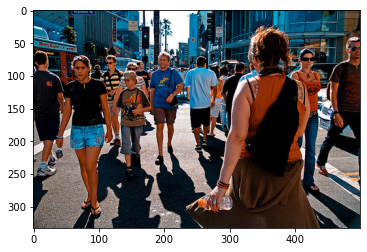

In [78]:
example('1174629344_a2e1a2bdbf', final_model,
        test_image_features_xcptn['1174629344_a2e1a2bdbf'], tokenizer, max_length)

## Better Caption

Actual Captions:

strstart group of dogs pull person on dog sled up hill strend
strstart dogsled rider pulled past flags on snowy hill strend
strstart dogs pulling sled in sled race strend
strstart five sled dogs are pulling person on sled through the snow strend
strstart the man is mushing his dogs on snow trail strend

 Predicted Caption:

1/1 [==============================] - 0s 2ms/step
strstart two people are playing in the snow strend


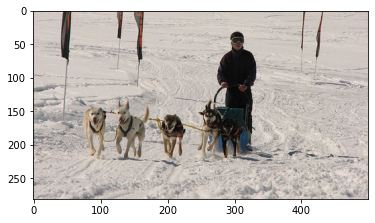

In [79]:
example('1287073593_f3d2a62455', final_model,
        test_image_features_xcptn['1287073593_f3d2a62455'], tokenizer, max_length)

## Bad Caption

Actual Captions:

strstart boy is jumping on bed strend
strstart boy jumped up from the green bed strend
strstart boy jumps from one bed to another strend
strstart small child is jumping on bed strend
strstart the boy in blue shorts is bouncing on the bed strend

 Predicted Caption:

1/1 [==============================] - 0s 2ms/step
strstart the little girl is sitting on the grass strend


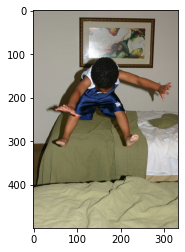

In [80]:
example('1131932671_c8d17751b3', final_model,
        test_image_features_xcptn['1131932671_c8d17751b3'], tokenizer, max_length)